# SELECT COASTAL ICE FROM NSIDC-0051 #

This notebook walks through the code for selecting just coastal cells from the National Snow and Ice Data Centers Sea Ice Concentrations from Nimbus-7 SMMR and DMSP SSM/I-SSMIS Passive Microwave Data, Version 2 (DATA SET ID: NSIDC-0051 and DOI: 10.5067/MPYG15WAA4WX). It also shows how to filter and sort the data into a useable and functional format for data analysis.

This has all been combined nicely into a python module. So if you do not want to know how this works you can just scroll all the way to the bottom and copy the code in the TLDR section. The tutorial is in five sections.

1. Access the Data
2. Select Coastal Cells
3. Wrap in Preprocessing Function
4. Account for Different Ice Concentration Variable Names
5. TLDR

### 1. Access the data ###

We start with importing the necessary libraries and authenticating earthaccess as show below.

In [103]:
import earthaccess
import xarray as xr
import dask
import numpy as np

In [104]:
auth = earthaccess.login(strategy='interactive', persist = True)

We then uses the earthaccess API to collect a list of results. When this is run for a larger data analysis project we use dates ranging from 1980 to 2023 but here we just show the month of January, 2021. We spefify which dataset we want using the short name (NSIDC-0051), specify the data range, specify that we want spefifically data from the arctic and not antarctic, and specify data that is hosted on the cloud through earthdata.

We are returned 32 results even though there are just 31 days in January. This is because we also get a monthly average of sea ice in January, 2021.

In [ ]:
results = earthaccess.search_data(
    short_name='NSIDC-0051',
    temporal=('2021-01-01', '2021-01-31'),
    bounding_box=(-180, 0, 180, 90),
    cloud_hosted=True
)

print(f"here we found {len(results)} results")
results[31]

We now can take our returned list of coastal ice data and use earth access's .open() function which will give us a list of file-like objects. For example files[0] returns https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/PM/NSIDC-0051/2/2021/01/01/NSIDC0051_SEAICE_PS_N25km_202101_v2.0.nc

This list of files is then converted into an XArray object using XArrays .open_mfdataset() functions with Dask parallel processing and combining by coordinates. This returns the dataset you can look through below. 

In [ ]:
files = earthaccess.open(results)
ds = xr.open_mfdataset(files, parallel=True, combine='by_coords')
ds

### 2. Select Coastal Cells ###

The next section goes over the code to select just the cells that border coasts. We define this as being within 3 grid cells of a coast however the code can be easily changed. Lets start by importing some more libraries to help with this.

In [105]:
import geopandas as gpd
import cartopy.feature as cfeature
from rasterio import features
from scipy.ndimage import convolve
from rasterio.transform import from_origin

Next we import a 1:10m land raster which has been downloaded into the data folder of this repo. You can find that here https://www.naturalearthdata.com/downloads/10m-physical-vectors/ as well. Not we have to convert this to epsg 3411 (https://epsg.io/3411) which is NSIDC Sea Ice Polar Stereographic North and is the coordinate system our data uses.

In [ ]:
land = gpd.read_file("../data/ne_10m_land/ne_10m_land.shp")
land = land.to_crs(epsg=3411)


Next we have to define our transform for rasterizing the data. Below we compute the spatial resolution and geographic origin of the grid and package it into a format needed to align spatial data correctly. 

These variables are specified in the metadata you can find in the previous section. The variables dx and dy are just the size of our grid cells (25,000) and the variables x0 and y0 represent the origin of the grid (-3837500.0 and -5337500.0 respectively). However we define these like this dx = float(ds.x.diff('x').mean()) instead of dx = 25,000 to be slightly more thorough for when this function is used for other datasets.

In [ ]:
dx = float(ds.x.diff('x').mean())
dy = float(ds.y.diff('y').mean())
# dx = 25000
# dy = -25000
x0 = float(ds.x.min())
y0 = float(ds.y.min())
# x0 = -3837500
# y0 = -5337500

transform = [dx, 0, x0, 0, -dy, y0]
transform


Next we use that tranform to rasterize the landmask and create a coastal mask. Finally we can convert that coastal mask to an XArray DataArray object and map it.

In [ ]:
land_mask = features.rasterize(
    ((geom, 1) for geom in land.geometry),
    out_shape=(ds.sizes['y'], ds.sizes['x']),
    transform=transform,
    fill=0,
    dtype=np.uint8
)

# create coastal mask (within 3 grid cells of land)

ocean = (land_mask == 0).astype(int)
kernel = np.ones((7, 7))
land_neighbor_count = convolve(1 - ocean, kernel, mode='constant', cval=0)
coastal_mask = (ocean == 1) & (land_neighbor_count > 0)

# convert to xarray.DataArray

coastal_mask_xr = xr.DataArray(
    coastal_mask,
    coords={'y': ds.y, 'x': ds.x},
    dims=('y', 'x')
)

# map the coastal filter

import matplotlib.pyplot as plt

coastal_mask_xr.plot()

Finally here are the results when we apply that mask to a day in our dataset and plot that.

In [ ]:
ds_masked = ds.where(coastal_mask_xr)
ds_masked.F17_ICECON.isel(time=0).plot(cmap='Blues', cbar_kwargs={'label': 'Sea Ice Concentration (%)'})

### 3. Wrap in Preprocessing Function ###

Now we can wrap everything into a function and use that in preprocessing when we download data. That would look something like this which as you can see returns the same results.

In [ ]:
def select_coastal(ds):

    # load land polygons and reproject to EPSG:3411

    land = gpd.read_file("../data/ne_10m_land/ne_10m_land.shp")
    land = land.to_crs(epsg=3411)

    # get transform for rasterizing

    dx = float(ds.x.diff('x').mean())  # 25000 meters
    dy = float(ds.y.diff('y').mean())  # 25000 meters
    x0 = float(ds.x.min())
    y0 = float(ds.y.min())
    transform = [dx, 0, x0, 0, -dy, y0]

    # rasterize land mask: 1 = land, 0 = ocean

    land_mask = features.rasterize(
        ((geom, 1) for geom in land.geometry),
        out_shape=(ds.sizes['y'], ds.sizes['x']),
        transform=transform,
        fill=0,
        dtype=np.uint8
    )

    # create coastal mask (within 3 grid cells of land)

    ocean = (land_mask == 0).astype(int)
    kernel = np.ones((7, 7))  # 3-cell radius
    land_neighbor_count = convolve(1 - ocean, kernel, mode='constant', cval=0)
    coastal_mask = (ocean == 1) & (land_neighbor_count > 0)

    # convert to xarray.DataArray

    coastal_mask_xr = xr.DataArray(
        coastal_mask,
        coords={'y': ds.y, 'x': ds.x},
        dims=('y', 'x')
    )

    # apply mask

    return ds.where(coastal_mask_xr)


Here we do the same process as in section one we just pass select_coastal() into preprocessing.

In [ ]:
# get results in earthaccess

results = earthaccess.search_data(
    short_name='NSIDC-0051',
    temporal=('2021-01-01', '2021-01-15'),
    bounding_box=(-180, 0, 180, 90),
    cloud_hosted=True
)

# open results with xarray

files = earthaccess.open(results)
ds = xr.open_mfdataset(files, parallel=True, combine='by_coords', preprocess=select_coastal)
ds.F17_ICECON.isel(time=0).plot(cmap='Blues', cbar_kwargs={'label': 'Sea Ice Concentration (%)'})

### 4. Accounting for Variations in Ice Concentration Variable Names

The next problem is that when we use larger time frames the satellite that measured ice concentrations has had different names over the years. The variable that stores ice concentration information also reflects these changing names.

In modern times the variable is named F17_ICECON, but in earlier years F8_ICECON is common. To show this I have concatenated results below from both 1990 and 2021. We are still just working with 30 days but now we have 30 days from many different time periods.

In [ ]:
# get results in earthaccess

results = earthaccess.search_data(
    short_name='NSIDC-0051',
    temporal=('2021-01-01', '2021-01-15'),
    bounding_box=(-180, 0, 180, 90),
    cloud_hosted=True
)

results += earthaccess.search_data(
    short_name='NSIDC-0051',
    temporal=('1990-01-01', '1990-01-15'),
    bounding_box=(-180, 0, 180, 90),
    cloud_hosted=True
)

# open results with xarray

files = earthaccess.open(results)
ds = xr.open_mfdataset(files, parallel=True, combine='by_coords', preprocess=select_coastal)
ds

We can combine the many named ice concentration data by iterating throught the dataset and selecting whatever the latest satellite was available at the time. This is parallelized using dask to make the operation as fast as possible. 

In [ ]:
from tqdm import tqdm

# this gets a list of ice concentration variables
icecon_vars = [var for var in ds.data_vars if 'ICECON'in var]
icecon_vars.sort(reverse=True)

# create template
temp = ds[icecon_vars[0]]
icecon = xr.full_like(temp, np.nan).chunk(temp.chunks)

for var in tqdm(icecon_vars, desc="combining ice concentration data"):
        data = ds[var]
        icecon = xr.where(xr.ufuncs.isnan(icecon), data, icecon)

# save dataset without extra sat data
ds["icecon"] = icecon
ds = ds.drop_vars(icecon_vars)

Now we can access sea ice concentration variables from any day without have to explicitly know what satellite was being used to track the sea ice concentration at that time. For example below is the code we might use to compare the difference in coastal sea ice extent between January 1, 1990 and January 1, 2021.

In [ ]:
difs = ds.icecon.isel(time=15) - ds.icecon.isel(time=0)
difs.plot()

### 5. TLDR ###

This notebook shows you how to take NSIDC data and do the following.

1) stream it from NASA's earthdata cloud services
2) select just the coastal cells in a very efficient parallelized manner
3) make sure ice concentration variable names are in a consistent format across time and across different products

This functionality has been combined into an easy to use python module called CNSIDC. You can simply copy the below code to do everything explained above in this notebook. Do note you have to have the CNSIDC.py file downloaded as well.

In [ ]:
from CNSIDC import ice_get, ice_combine

start_date = '2020-01-01'
end_date = '2020-01-31'

ds = ice_get('NSIDC-0051', start_date, end_date)
ds = ice_combine(ds)

ds.info

Or below is an example of a script that compares average sea ice measurements from NSIDC-0051 and NSIDC-0079 between January 1 - January 10, 1990.

QUEUEING TASKS | :   0%|          | 0/22 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/22 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/22 [00:00<?, ?it/s]

combining ice concentration data: 100%|██████████| 1/1 [00:00<00:00, 1034.35it/s]


QUEUEING TASKS | :   0%|          | 0/22 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/22 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/22 [00:00<?, ?it/s]

combining ice concentration data: 100%|██████████| 1/1 [00:00<00:00, 802.58it/s]


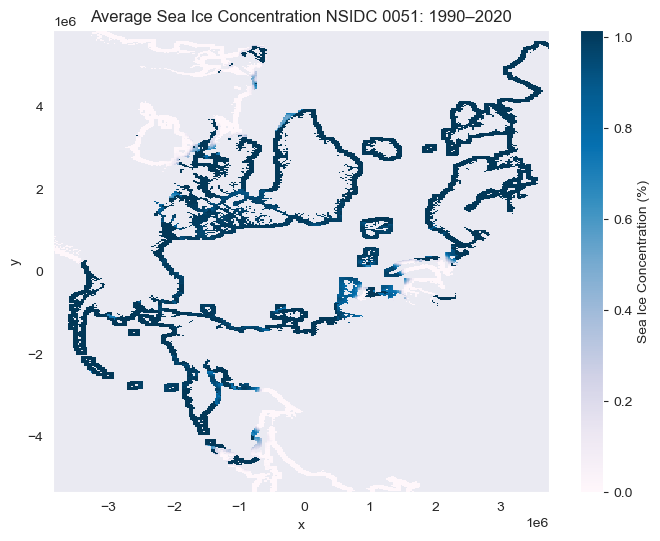

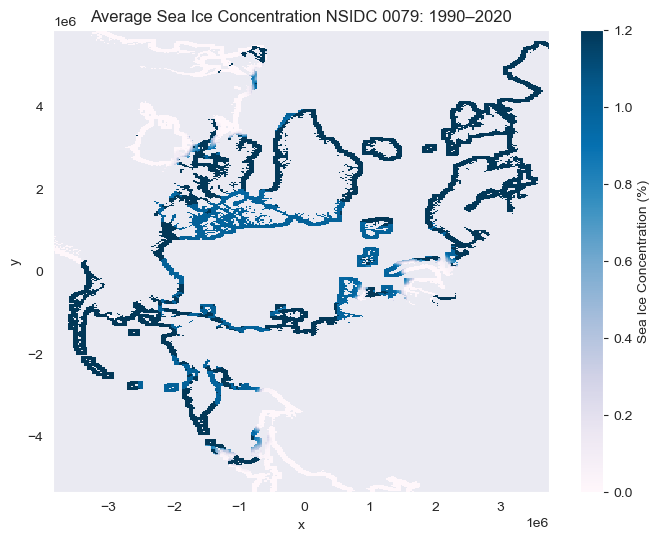

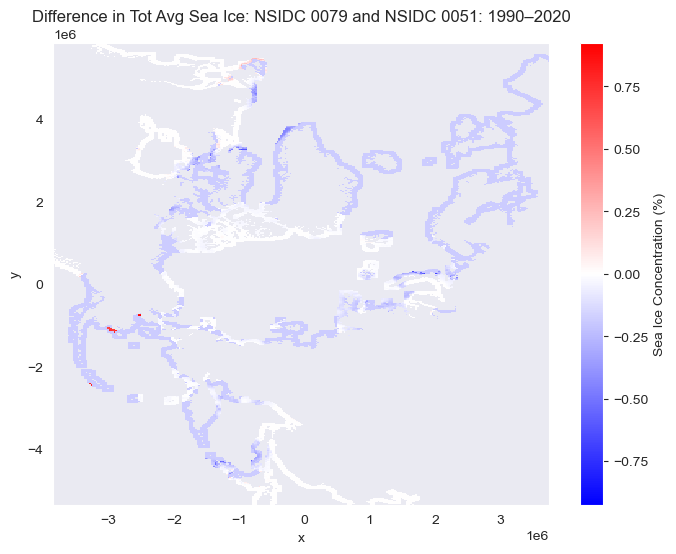

In [137]:
# general libraries
import earthaccess
import xarray as xr
import dask
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

# CNSIDC library
from CNSIDC import ice_get, ice_combine

# fetch data 1990-2020 for NSIDC 0051 and 0079

ds51 = ice_get('NSIDC-0051', '1990-01-01', '1990-01-10')
ds51 = ice_combine(ds51)

ds79 = ice_get('NSIDC-0079', '1990-01-01', '1990-01-10')
ds79 = ice_combine(ds79)

# average entire dataset

ds51_avg = ds51.icecon.mean(dim='time')
ds79_avg = ds79.icecon.mean(dim='time')

# get difference array

ds_avg_dif = ds51_avg - ds79_avg

# Plot 1
fig, ax = plt.subplots(figsize=(8, 6))
ds51_avg.plot(ax=ax, cmap='PuBu', cbar_kwargs={'label': 'Sea Ice Concentration (%)'})
ax.set_title("Average Sea Ice Concentration NSIDC 0051: 1990–2020")
fig.savefig("../figures/NSIDC0051_TOTAL_AVG.png", dpi=300, bbox_inches='tight')
plt.show(fig)
plt.close(fig)

# Plot 2
fig, ax = plt.subplots(figsize=(8, 6))
ds79_avg.plot(ax=ax, cmap='PuBu', cbar_kwargs={'label': 'Sea Ice Concentration (%)'})
ax.set_title("Average Sea Ice Concentration NSIDC 0079: 1990–2020")
fig.savefig("../figures/NSIDC0079_TOTAL_AVG.png", dpi=300, bbox_inches='tight')
plt.show(fig)
plt.close(fig)

# Plot 3: Difference
fig, ax = plt.subplots(figsize=(8, 6))
ds_avg_dif.plot(ax=ax, cmap='bwr', cbar_kwargs={'label': 'Sea Ice Concentration (%)'})
ax.set_title("Difference in Tot Avg Sea Ice: NSIDC 0079 and NSIDC 0051: 1990–2020")
fig.savefig("../figures/TOTAL_AVG_DIF.png", dpi=300, bbox_inches='tight')
plt.show(fig)
plt.close(fig)